Reference: https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

In [1]:
### Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
torch.manual_seed(123)

### Embedding Representation


In [2]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}

print(dc)

sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])
print(sentence_int)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}
tensor([0, 4, 5, 2, 1, 3])


In [3]:
vocab_size = 50_000

torch.manual_seed(123)
embed = torch.nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [-0.2196, -0.3792,  0.7671],
        [-0.5880,  0.3486,  0.6603],
        [-1.1925,  0.6984, -1.4097]])
torch.Size([6, 3])


### Defining Weight Matrices

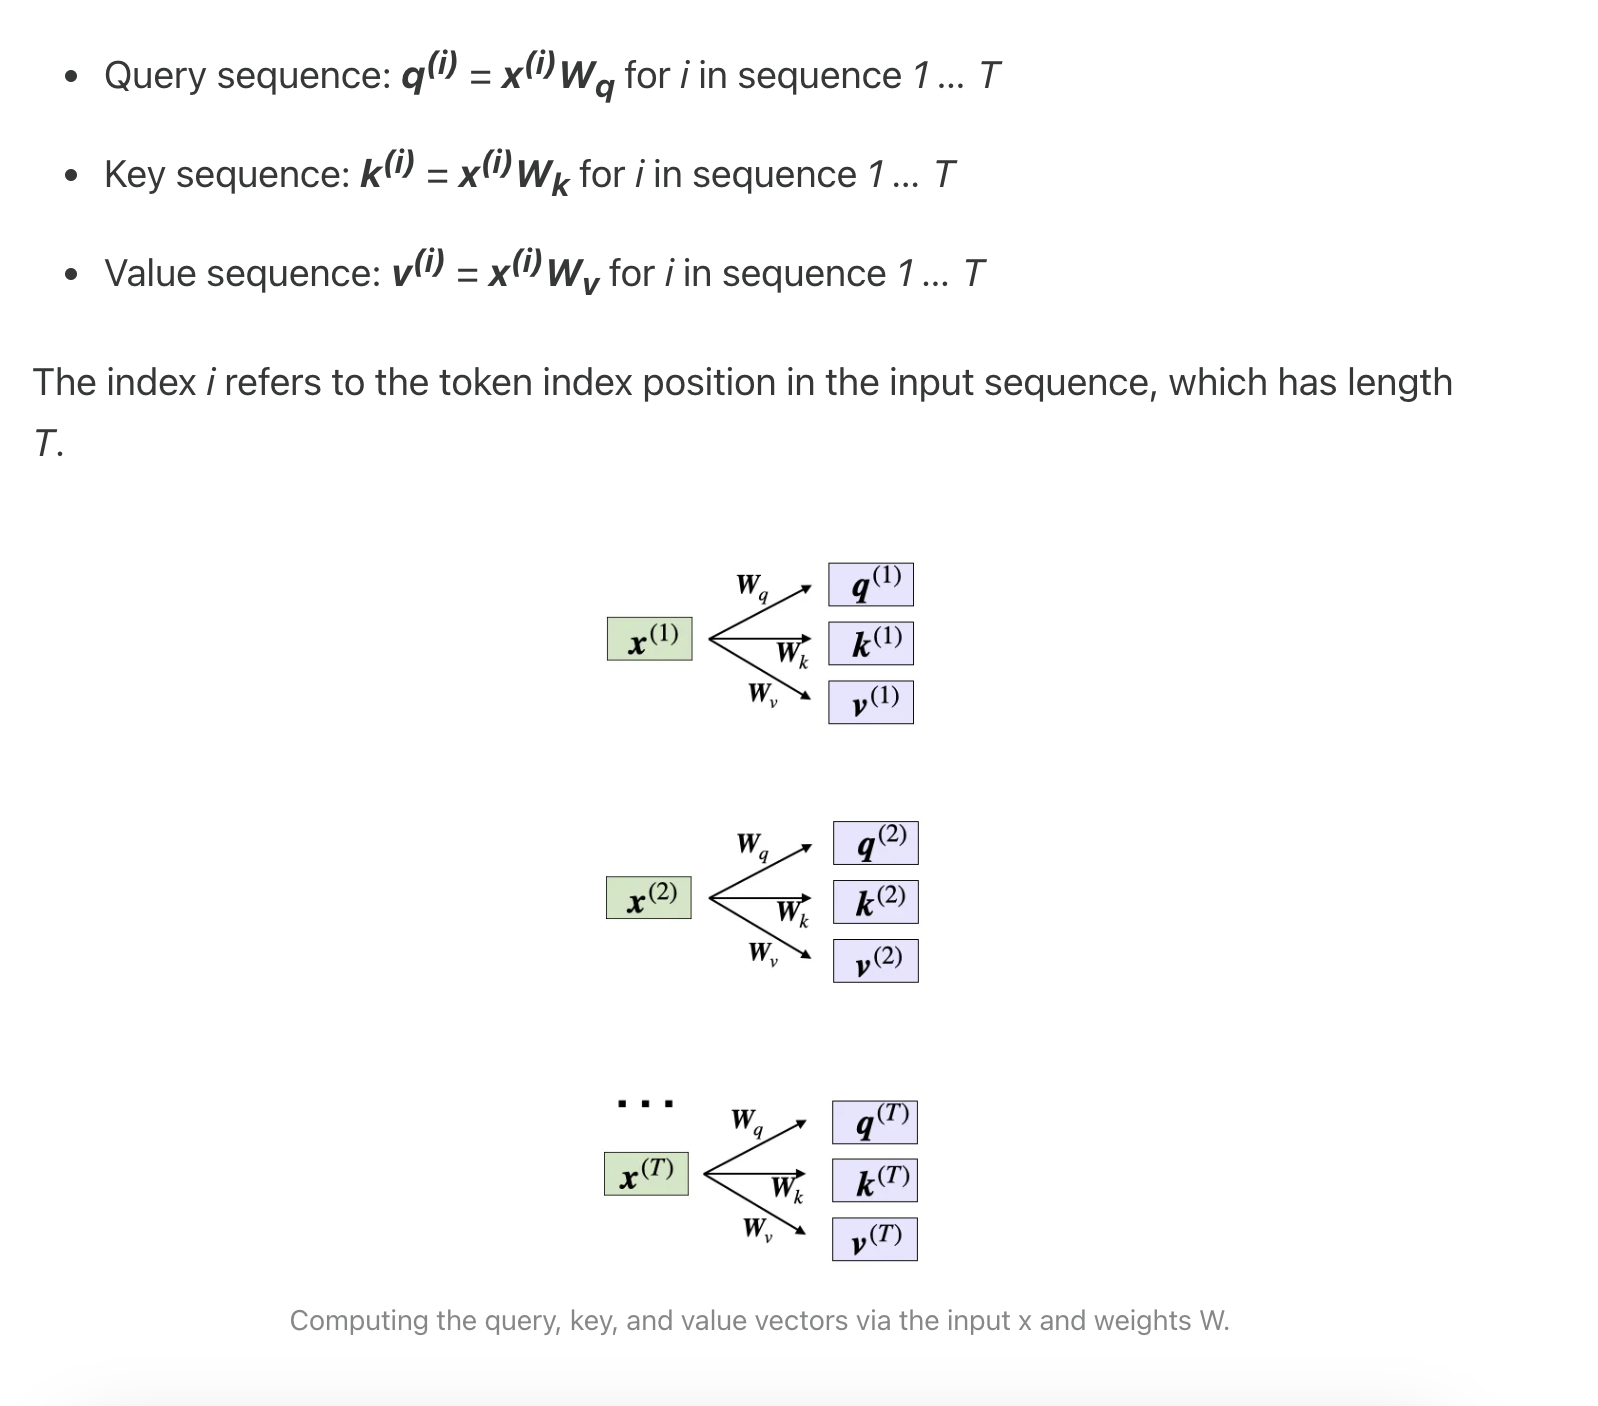

In [15]:
d = embedded_sentence.shape[1]
d_q, d_k, d_v = 2, 2, 4

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

print(f"d={d}; d_q={d_q}; d_k={d_k}; d_v={d_v}")

d=3; d_q=2; d_k=2; d_v=4


### Computing the Unnormalized Attention Weights

In [16]:
### Example for One sentence
x_2 = embedded_sentence[1]
x_2

tensor([0.1794, 1.8951, 0.4954])

In [17]:

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

torch.Size([2])
torch.Size([2])
torch.Size([4])


In [18]:
### For all the sentences
keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 4])


### Generating q.k values

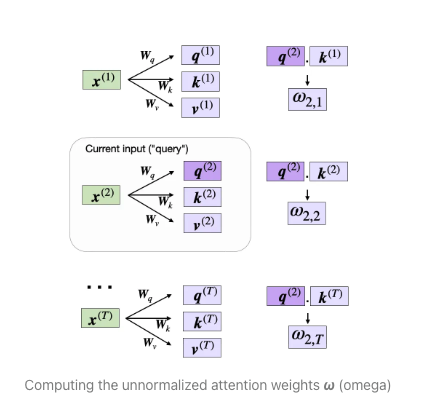

In [19]:
## For one query key pair
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(1.2903, grad_fn=<DotBackward0>)


In [20]:
## For one query with all keys
omega_2 = query_2 @ keys.T
print(omega_2.shape)

torch.Size([6])


### Softmax
Rescales them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.

https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

### Normalization and Computing the Attention Weights
The scaling by dk ensures that the Euclidean length of the weight vectors will be approximately in the same magnitude. This helps prevent the attention weights from becoming too small or too large, which could lead to numerical instability or affect the model's ability to converge during training.

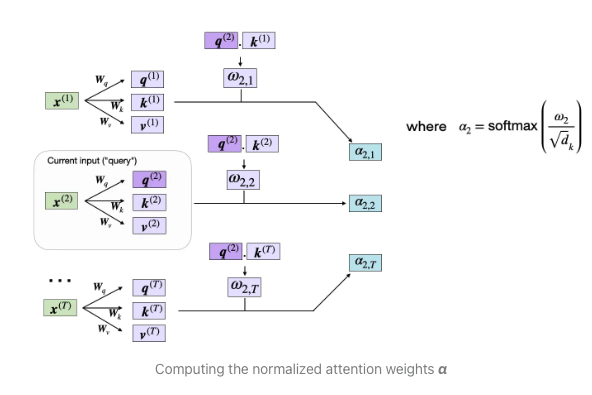

In [21]:
attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
       grad_fn=<SoftmaxBackward0>)


 compute the context vector z(2), which is an attention-weighted version of our original query input x(2)

 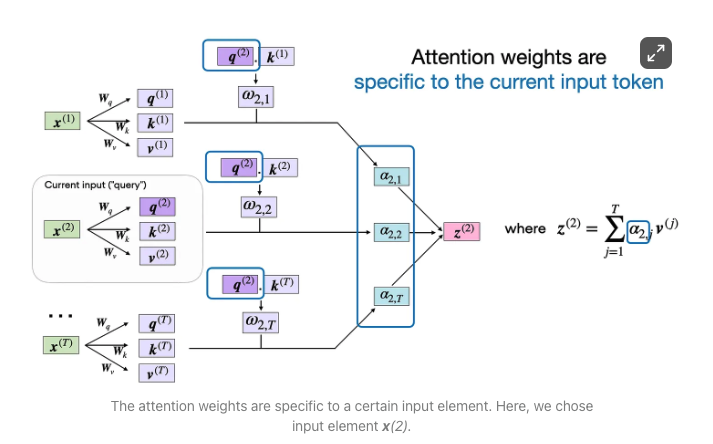

In [22]:
context_vector_2 = attention_weights_2 @ values

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([4])
tensor([0.5313, 1.3607, 0.7891, 1.3110], grad_fn=<SqueezeBackward4>)


### Formulating as a Self Attention Module

In [23]:
class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T  # unnormalized attention weights
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [24]:
# reduce d_out_v from 4 to 1, because we have 4 heads
torch.manual_seed(123)
d_in, d_out_kq, d_out_v = 3, 2, 4

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.1564,  0.1028, -0.0763, -0.0764],
        [ 0.5313,  1.3607,  0.7891,  1.3110],
        [-0.3542, -0.1234, -0.2626, -0.3706],
        [ 0.0071,  0.3345,  0.0969,  0.1998],
        [ 0.1008,  0.4780,  0.2021,  0.3674],
        [-0.5296, -0.2799, -0.4107, -0.6006]], grad_fn=<MmBackward0>)


If you look at the second row, you can see that it matches the values in context_vector_2 from the previous section exactly: tensor([0.5313, 1.3607, 0.7891, 1.3110])

## Multi Head Attention

In [25]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
    super().__init__()
    self.heads = nn.ModuleList(
        [SelfAttention(d_in, d_out_kq, d_out_v)
          for _ in range(num_heads)]
    )
  def forward(self, x):
      return torch.cat([head(x) for head in self.heads], dim=-1)

In [27]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 1
sa = SelfAttention(d_in, d_out_kq, d_out_v)

print(sa(embedded_sentence))

tensor([[-0.0185],
        [ 0.4003],
        [-0.1103],
        [ 0.0668],
        [ 0.1180],
        [-0.1827]], grad_fn=<MmBackward0>)


In [28]:
torch.manual_seed(123)

block_size = embedded_sentence.shape[1]
mha = MultiHeadAttentionWrapper(
    d_in, d_out_kq, d_out_v, num_heads=4
)

context_vecs = mha(embedded_sentence)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[-0.0185,  0.0170,  0.1999, -0.0860],
        [ 0.4003,  1.7137,  1.3981,  1.0497],
        [-0.1103, -0.1609,  0.0079, -0.2416],
        [ 0.0668,  0.3534,  0.2322,  0.1008],
        [ 0.1180,  0.6949,  0.3157,  0.2807],
        [-0.1827, -0.2060, -0.2393, -0.3167]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([6, 4])


Notice that the multi-head attention result is a 6×4-dimensional tensor: We have 6 input tokens and 4 self-attention heads, where each self-attention head returns a 1-dimensional output. Previously, in the Self-Attention section, we also produced a 6×4-dimensional tensor. That's because we set the output dimension to 4 instead of 1. In practice, why do we even need multiple attention heads if we can regulate the output embedding size in the SelfAttention class itself?

The distinction between increasing the output dimension of a single self-attention head and using multiple attention heads lies in how the model processes and learns from the data.

While both approaches increase the capacity of the model to represent different features or aspects of the data, they do so in fundamentally different ways.

For instance,** each attention head in multi-head attention can potentially learn to focus on different parts of the input sequence**, capturing various aspects or relationships within the data. This diversity in representation is key to the success of multi-head attention.

**Multi-head attention can also be more efficient, especially in terms of parallel computation. Each head can be processed independently, making it well-suited for modern hardware accelerators like GPUs or TPUs that excel at parallel processing.**

In short, the use of multiple attention heads is not just about increasing the model's capacity but about enhancing its ability to learn a diverse set of features and relationships within the data. For example, the 7B Llama 2 model uses 32 attention heads.

## Cross Attention

Note that in cross-attention, the two input sequences x_1 and x_2 can have different numbers of elements. However, their embedding dimensions must match

In [29]:
class CrossAttention(nn.Module):

  def __init__(self, d_in, d_out_kq, d_out_v):
      super().__init__()
      self.d_out_kq = d_out_kq
      self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
      self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
      self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

  def forward(self, x_1, x_2):           # x_2 is new
      queries_1 = x_1 @ self.W_query

      keys_2 = x_2 @ self.W_key          # new
      values_2 = x_2 @ self.W_value      # new

      attn_scores = queries_1 @ keys_2.T # new
      attn_weights = torch.softmax(
          attn_scores / self.d_out_kq**0.5, dim=-1)

      context_vec = attn_weights @ values_2
      return context_vec

The differences between the CrossAttention class and the previous SelfAttention class are as follows:

1. The forward method takes two distinct inputs, x_1 and x_2. The queries are derived from x_1, while the keys and values are derived from x_2. This means that the attention mechanism is evaluating the interaction between two different inputs.

2. The attention scores are calculated by taking the dot product of the queries (from x_1) and keys (from x_2).

3. Similar to SelfAttention, each context vector is a weighted sum of the values. However, in CrossAttention, these values are derived from the second input (x_2), and the weights are based on the interaction between x_1 and x_2.

In [31]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

##  first and second inputs don't have to have the same number of tokens (here: rows) when computing cross-attention
first_input = embedded_sentence
second_input = torch.rand(8, d_in)

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)

First input shape: torch.Size([6, 3])
Second input shape: torch.Size([8, 3])


## Causal / Masked Self-Attention

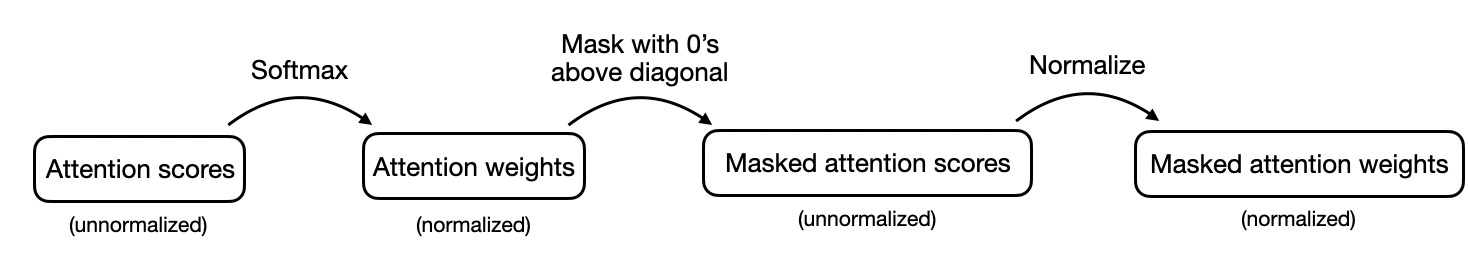

Attention scores are just q.k before normalization/softmax

Attention weights are softmax(qk/root(dk)) and before multiplying with values.

In [36]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
W_value = nn.Parameter(torch.rand(d_in, d_out_v))

x = embedded_sentence

keys = x @ W_key
queries = x @ W_query
values = x @ W_value

# attn_scores are the "omegas", the unnormalized attention weights
attn_scores = queries @ keys.T

print(attn_scores)
print(attn_scores.shape)

attn_weights = torch.softmax(attn_scores / d_out_kq**0.5, dim=1)
print(attn_weights)
print(attn_weights.shape)

tensor([[ 0.0613, -0.3491,  0.1443, -0.0437, -0.1303,  0.1076],
        [-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
        [ 0.2432, -1.3934,  0.5869, -0.1851, -0.5191,  0.4730],
        [-0.0794,  0.4487, -0.1807,  0.0518,  0.1677, -0.1197],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216, -0.2787],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MmBackward0>)
torch.Size([6, 6])
tensor([[0.1772, 0.1326, 0.1879, 0.1645, 0.1547, 0.1831],
        [0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
        [0.1965, 0.0618, 0.2506, 0.1452, 0.1146, 0.2312],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.1793, 0.1463],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.1231],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)
torch.Size([6, 6])


### Method 1 - Apply lower triangular Mask of 1s on Attention weights

In [37]:
block_size = attn_weights.shape[0] # both scores and weights share the same shape
mask_simple = torch.tril(torch.ones(block_size, block_size)) ## Lower triangular marks
print(mask_simple)

masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0.1772, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0386, 0.6870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1965, 0.0618, 0.2506, 0.0000, 0.0000, 0.0000],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.0000, 0.0000],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<MulBackward0>)


While the above is one way to mask out future words, notice that the attention weights in each row don't sum to one anymore. To mitigate that, we can normalize the rows such that they sum up to 1 again, which is a standard convention for attention weights.

First, normalized attention weights that sum to 1 resemble a probability distribution. This makes it easier to interpret the model's attention to various parts of the input in terms of proportions. Second, by constraining the attention weights to sum to 1, this normalization helps control the scale of the weights and gradients to improve the training dynamics.

This normalization is needed since the mask is applied after the softmax and need to still add to 1

In [38]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<DivBackward0>)


### Method 2 - Upper triangle mask of -infs on Attention scores before norm/softmax
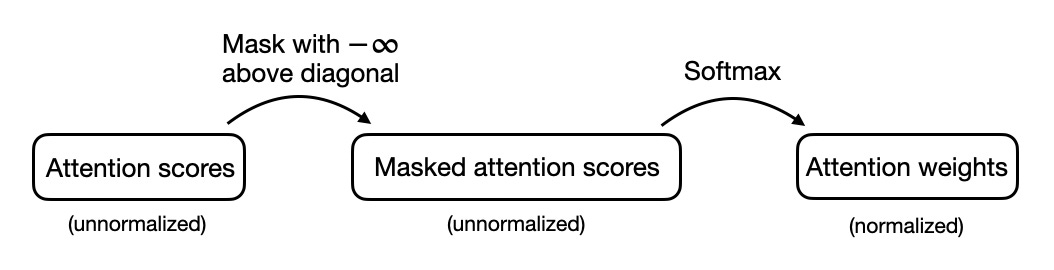

In [39]:
mask = torch.triu(torch.ones(block_size, block_size), diagonal=1)
print(mask)

masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[ 0.0613,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.6004,  3.4707,    -inf,    -inf,    -inf,    -inf],
        [ 0.2432, -1.3934,  0.5869,    -inf,    -inf,    -inf],
        [-0.0794,  0.4487, -0.1807,  0.0518,    -inf,    -inf],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216,    -inf],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MaskedFillBackward0>)


In [40]:
## Then, apply the softmax function as usual to obtain the normalized and masked attention weights
attn_weights = torch.softmax(masked / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)


In [47]:
### Trainium Experiments on Self Attention Module